In [1]:
import numpy as np
from terrainbento import BasicChSa
import matplotlib.pyplot as plt
from landlab import imshow_grid

In [2]:
linear_diffusivity = 1.0
slope_crit = 0.3
nterms = 11
uplift_rate = 0.0005
node_spacing = 10.0
max_soil_production_rate = 1e-3
soil_production_decay_depth = 0.2
soil_transport_decay_depth = 0.2
h_star = 0.1
p = np.zeros(2*nterms-1)
dt = 1.0

Let's say the nodes are numbered from 0 to 100, 50 being the top of the hillslope. That means the flux at node 90 needs to be able to transport all of the material from the crest to its own node (we use the second penultimate node to avoid boundary complications). Since node spacing is 10.0, this means that the flux at the last node should be: 

In [3]:
#x = (99-50)*10 + 5
x = 490
qs = uplift_rate*x

In [4]:
qs

0.245

Since this is a depth-dependent model, we can calculate the expected soil depth for a given uplift rate:

In [5]:
steady_H = -soil_production_decay_depth*np.log(uplift_rate/max_soil_production_rate)
steady_H

0.13862943611198905

Since $qs = KS(1+(\frac{S}{Sc})^2 +...+ \frac{S}{Sc}^{2(n-1)})$, we can bring qs to the right side of the equation and get $ 0 = -qs + KS*(1-e^{-H/h*})*(1+(\frac{S}{Sc})^2 +...+ \frac{S}{Sc}^{2(n-1)})$. We need to define the coefficients of the polynomial. First looking at the higher order terms:

In [6]:
for i in range(1,nterms+1):
      p[2*i-2] = linear_diffusivity*(1-np.exp(-steady_H/soil_transport_decay_depth))*(1/(slope_crit**(2*(i-1))))

In [7]:
p = np.fliplr([p])[0]

In [8]:
p

array([  1.43398600e+10,   0.00000000e+00,   1.29058740e+09,
         0.00000000e+00,   1.16152866e+08,   0.00000000e+00,
         1.04537579e+07,   0.00000000e+00,   9.40838212e+05,
         0.00000000e+00,   8.46754390e+04,   0.00000000e+00,
         7.62078951e+03,   0.00000000e+00,   6.85871056e+02,
         0.00000000e+00,   6.17283951e+01,   0.00000000e+00,
         5.55555556e+00,   0.00000000e+00,   5.00000000e-01])

In [9]:
p = np.append(p,qs)

In [10]:
p_roots = np.roots(p)
p_roots

array([ 0.29354301+0.07608549j,  0.29354301-0.07608549j,
        0.26740488+0.15421134j,  0.26740488-0.15421134j,
        0.21750160+0.22489098j,  0.21750160-0.22489098j,
        0.14731595+0.27903263j,  0.14731595-0.27903263j,
        0.06325132+0.31056136j,  0.06325132-0.31056136j,
       -0.02697138+0.31607306j, -0.02697138-0.31607306j,
       -0.11508529+0.29473901j, -0.11508529-0.29473901j,
       -0.19296338+0.2482119j , -0.19296338-0.2482119j ,
       -0.25323462+0.18032674j, -0.25323462-0.18032674j,
       -0.28976641+0.09627099j, -0.28976641-0.09627099j, -0.22199136+0.j        ])

In [11]:
steady_S = np.real(p_roots[-1])
print(steady_S)

-0.221991362829


In [12]:
steady_S = abs(steady_S)
print(steady_S)

0.221991362829


Now run the erosion model and test against this steady state prediction. 

In [13]:
#parameter dictionary
params = {'number_of_node_rows' : 10,
         'number_of_node_columns' : 100,
         'node_spacing' : 10.0,
         'east_boundary_closed' : False,
         'north_boundary_closed' : True,
         'west_boundary_closed' : False,
         'south_boundary_closed' :True,
         'dt' : dt,
         'K_sp' : 0,
         'm_sp' : 0.5,
         'n_sp' : 1.0,
         'linear_diffusivity' : linear_diffusivity,
         'slope_crit' : slope_crit,
         'max_soil_production_rate' : max_soil_production_rate,
         'soil_production_decay_depth' : soil_production_decay_depth,
         'soil_transport_decay_depth' : soil_transport_decay_depth,
         'outlet_lowering_rate' : uplift_rate,
         'initial_soil_thickness' : 0.0,
         'output_filename': 'model_040_output',}

In [14]:
basic = BasicChSa(params=params)
tolerance = 0.000001



In [15]:
elapsed_time = 0
keep_running = True
while keep_running == True:
    
    pre_topo = basic.grid.at_node['topographic__elevation'][basic.grid.core_nodes]
   
    basic.run_one_step(dt)
    
    #slope1 = basic.grid.at_node['topographic__steepest_slope'][101]
    #slope2 = basic.grid.at_node['topographic__steepest_slope'][189]
    
    post_topo = basic.grid.at_node['topographic__elevation'][basic.grid.core_nodes]
    
      
    if elapsed_time % 10000 == 0:
        print(elapsed_time)
        #print slope1-steady_S
        #print basic.grid.at_node['soil__depth'][189]
        #print basic.grid.at_node['soil__depth'][15]
        print(max(abs(pre_topo - post_topo)))
    elapsed_time += dt
    
    #if abs((slope1-steady_S)) <= tolerance and abs((slope2-steady_S)) <= tolerance:
     #   keep_running = False
    if max(abs(pre_topo - post_topo)) <= tolerance: 
        keep_running = False

0
0.0005
10000.0
0.000499841559099
20000.0
0.00049051719067
30000.0
0.0004708919243
40000.0
0.000447430444375
50000.0
0.000422525964158
60000.0
0.000397226289213
70000.0
0.000372393048551
80000.0
0.000348265107405
90000.0
0.000324925544248
100000.0
0.000302409135465
110000.0
0.000280735223058
120000.0
0.000259921830782
130000.0
0.000239990144124
140000.0
0.000220964342006
150000.0
0.000202869407438
160000.0
0.000185728322812
170000.0
0.000169559407802
180000.0
0.000154374189137
190000.0
0.000140175967097
200000.0
0.000126959102097
210000.0
0.000114708956914
220000.0
0.00010340238002
230000.0
9.30085938222e-05
240000.0
8.34903502636e-05
250000.0
7.48052283939e-05
260000.0
6.69069687973e-05
270000.0
5.97467630996e-05
280000.0
5.32744406883e-05
290000.0
4.74395152139e-05
300000.0
4.21920723142e-05
310000.0
3.74834930454e-05
320000.0
3.3267018722e-05
330000.0
2.94981690416e-05
340000.0
2.61350301258e-05
350000.0
2.31384307909e-05
360000.0
2.04720257386e-05
370000.0
1.8102303784e-05
380000.

Check that slopes at edges match expectation

In [32]:
slope1 = basic.grid.at_node['topographic__steepest_slope'][101]
slope2 = basic.grid.at_node['topographic__steepest_slope'][189]

slope1 - steady_S
slope2 - steady_S

-0.014156513671079896

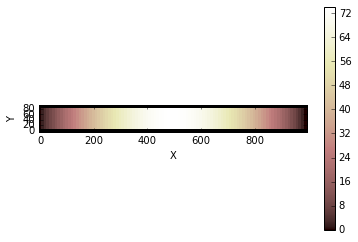

In [17]:
%matplotlib inline
imshow_grid(basic.grid, 'topographic__elevation')

In [18]:
slope1

0.22193476471006895

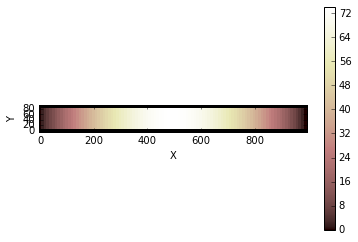

In [19]:
%matplotlib inline
imshow_grid(basic.grid, 'topographic__elevation')

100

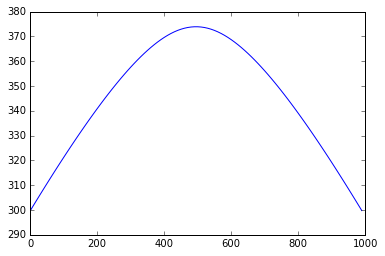

In [20]:
topo_profile = basic.grid.at_node['topographic__elevation'][basic.grid.node_y == 10] + uplift_rate*elapsed_time
domain = np.arange(0, max(basic.grid.node_x + 10.0), 10.0)
plt.plot(domain,topo_profile)
len(topo_profile)

In [28]:
basic.grid.at_node['topographic__steepest_slope']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [22]:
elapsed_time

599534.0

In [23]:
basic.grid.at_node['soil__depth']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [24]:
diff = max(abs(basic.grid.at_node['topographic__elevation'][basic.grid.core_nodes] - basic.grid.at_node['topographic__elevation][basic.grid.core_nodes]))
   

SyntaxError: EOL while scanning string literal (<ipython-input-24-afd96a51828d>, line 1)

In [ ]:
import matplotlib
from matplotlib import ticker
#plotting param
matplotlib.rcParams.update({'font.size': 20})


##instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
hillslope = plt.subplot()

#plotting param
matplotlib.rcParams.update({'font.size': 20})

#parameters
uplift_rate = 0.0005
hillslope_diffusivity = 1.0

#plot the actual profile
domain = np.arange(0, max(basic.grid.node_x + dx), dx)
x = np.arange(-max(domain) / 2., max(domain) / 2. + dx, dx)

hillslope.plot(domain/1000 , topo_profile, marker='o', c='k', linewidth = 0, markerfacecolor='None', label = 'Numerical Solution')

#plot the theoretical profile

#plt.plot((x + max(x)) / 1000, steady_z_profile , linestyle='-', c='grey', linewidth = 2, label = 'Analytical Solution')

#axis labels
hillslope.set_xlabel('Distance [km]')
hillslope.set_ylabel('Elevation [m]')

#legend
#hillslope.legend(scatterpoints = 1, prop={'size':12})

#save figure
fig.savefig('cubic_depth_dependent_topo.eps',bbox_inches='tight', dpi=300)
